In [4]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=f9fef4d251a989f911ada1cc4599a5f54caac9c7fe386a099129d7165a229fed
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [5]:
import os
import sys
import re
import string
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, array_join, split
from pyspark.sql.functions import lower, col
from pyspark.ml.feature import StopWordsRemover

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [6]:
def init_spark():
  spark = SparkSession.builder.appName("BigData").getOrCreate()
  sc = spark.sparkContext
  return spark,sc

In [7]:
def load_data_from_json(spark, file_name):
    return spark.read.json(file_name)

In [34]:
# fill ALL NULL values with empty string : use after removing rows with empty fields
def fill_na_with_empty_string(df):
    return df.fillna("")

# remove rows with empty fields
def remove_empty_fields(df, field_name):
    return df.filter(df[field_name] != "")

# remove "\n" from text
def remove_empty_newlines(df, field_name):
    return df.withColumn(field_name, regexp_replace(col(field_name), "\n", " "))

# remove math formulas and latex
def remove_math_formula(df, field_name):
    return df.withColumn(field_name, regexp_replace(col(field_name), "\$.*?\$", ""))

# convert to lowercase
def convert_to_lowercase(df, field_name):
    return df.withColumn(field_name, lower(col(field_name)))

# remove extra spaces
def remove_extra_spaces(df, field_name):
    df = df.withColumn(field_name, regexp_replace(col(field_name), " +", " "))
    df = df.withColumn(field_name, regexp_replace(col(field_name), "^ +", ""))
    return df

# remove punctuation
def remove_punctuation(df, field_name):
  return df.withColumn(field_name, regexp_replace(col(field_name), "[^\w\s]", ""))

# remove stop words
def remove_stop_words(df, field_name, output_field, stop_words):
  df = df.withColumn("tokens", split(field_name, "\\s+"))
  remover = StopWordsRemover(stopWords=stop_words, inputCol="tokens", outputCol=output_field)
  return remover.transform(df).select(field_name, "categories", array_join(output_field, " ").alias(output_field))

In [35]:
from pyspark.ml.feature import Word2Vec
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

In [36]:
def tokenize_dataset(dataset, input_col, output_col):
  tokenizer = Tokenizer(inputCol=input_col, outputCol=output_col)
  return tokenizer.transform(dataset)

def vectorize_dataset(dataset, input_col, output_col):
  dataset = remove_extra_spaces(dataset, "categories")
  words2vec_model = Word2Vec(inputCol="words",
                             outputCol=output_col,
                             vectorSize=100,
                             minCount=1)
  return words2vec_model.fit(tokenize_dataset(dataset, input_col, "words"))

def prepare_data(dataset, output_col='scaled_categories', input_col="categories"):
  scaler = StandardScaler(inputCol="vector",
                          outputCol=output_col,
                          withStd=True,
                          withMean=False)
  model = vectorize_dataset(dataset, input_col, "vector")
  scalerModel = scaler.fit(model.getVectors())
  # data.select('scaled_categories').show(5)
  return scalerModel.transform(model.getVectors())

In [37]:
def show_silhouette_score_graph(dataset):
  silhouette_score = []
  evaluator = ClusteringEvaluator(predictionCol="prediction",
                                  featuresCol='scaled_categories',
                                  metricName='silhouette',
                                  distanceMeasure='squaredEuclidean')
  dataset = prepare_data(dataset)
  for i in range(2,10):
    kmeans=KMeans(featuresCol='scaled_categories', k=i)
    model=kmeans.fit(dataset)
    predictions=model.transform(dataset)
    score=evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print('Silhouette Score for k =',i,'is',score)

  # Choose k = 4
  plt.plot(range(2,10),silhouette_score)
  plt.xlabel('k')
  plt.ylabel('silhouette score')
  plt.title('Silhouette Score')
  plt.show()

In [38]:
def create_clusters(dataset, k_value):
  kmeans = KMeans(featuresCol='scaled_categories', k=k_value)
  return kmeans.fit(prepare_data(dataset))

def create_predictions(model, dataset):
  return model.transform(prepare_data(dataset))

Silhouette Score for k = 2 is 0.8712134223386695
Silhouette Score for k = 3 is 0.7964836256855176
Silhouette Score for k = 4 is 0.471275224822888
Silhouette Score for k = 5 is 0.5766462647007761
Silhouette Score for k = 6 is 0.17930659252796172
Silhouette Score for k = 7 is 0.6337258811502738
Silhouette Score for k = 8 is 0.5258726164388552
Silhouette Score for k = 9 is 0.673833773194186


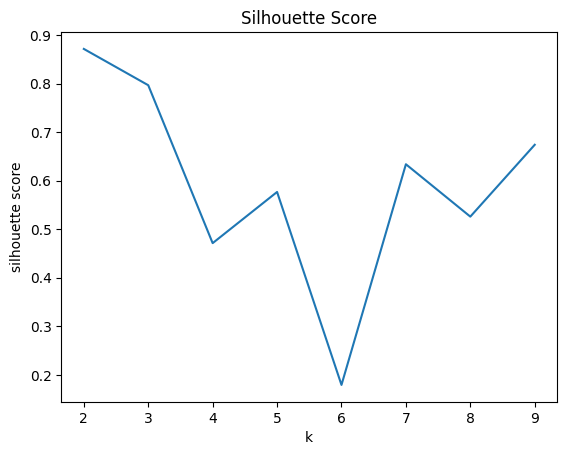

Cluster Centers: 
[-0.11336311 -0.07715598  0.17590764 -0.09177994 -0.01472376 -0.04116712
 -0.03129891  0.02300942 -0.10781251 -0.00491415  0.06512803 -0.01477276
  0.0640386   0.02217586  0.10513162 -0.12141188  0.12589383 -0.06265354
 -0.11485901 -0.04486848  0.00772978 -0.10828739 -0.02181024  0.03259531
 -0.11394128  0.09482425 -0.12715355 -0.10139549 -0.12572912 -0.11084538
  0.1578728  -0.09696535  0.02645111  0.00954739 -0.06983613  0.11756025
  0.05413116 -0.20235685 -0.02696679  0.08405457 -0.10180149  0.0272913
  0.02665318 -0.09667081  0.10902331 -0.09130203 -0.08843302  0.10088587
  0.09197205 -0.00030967 -0.02464646 -0.15679943 -0.07808917 -0.11736498
 -0.06966476  0.11294051  0.01261731  0.12527258 -0.1086604  -0.04986056
 -0.07562211 -0.06694977  0.1076416   0.09070082 -0.13078054  0.15041894
  0.10452008  0.08642944 -0.17418374  0.01616743  0.0111745   0.02325361
 -0.09468469 -0.03289052 -0.10510296 -0.17592731 -0.11489598  0.01095522
 -0.14452258 -0.1147717   0.056039

In [39]:
def run():
  sc = init_spark()[0]
  arxiv_dataset = load_data_from_json(sc, "part1.json")

  show_silhouette_score_graph(arxiv_dataset)

  model = create_clusters(arxiv_dataset, 4)
  print("Cluster Centers: ")
  for center in model.clusterCenters():
    print(center)

  create_predictions(model, arxiv_dataset).select('prediction').show(10)

run()

In [22]:
from operator import contains
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from pyspark.ml.feature import Tokenizer
from pyspark.sql import functions

In [23]:
def prepare_dataset(dataset):
  dataset = remove_empty_fields(dataset, "abstract")
  dataset = remove_empty_newlines(dataset, "abstract")
  dataset = remove_math_formula(dataset, "abstract")
  dataset = convert_to_lowercase(dataset, "abstract")
  dataset = remove_extra_spaces(dataset, "abstract")
  return dataset

In [24]:
def show_word_cloud(dataset, category):
  text =  " ".join(dataset.filter(dataset.categories.contains(category)).select("abstract").rdd.flatMap(lambda x: x).collect())
  wordcloud = WordCloud().generate(text)

  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [28]:
def show_word_top(dataset, category, count):
  dataset = remove_stop_words(dataset, "abstract", "filtered_abstract", list(STOPWORDS))
  dataset = dataset.filter(dataset.categories.contains(category))
  dataset = dataset.withColumn('filtered_abstract', functions.explode(functions.split('filtered_abstract', ' '))).groupBy('filtered_abstract').count().orderBy(functions.desc('count'))
  top_val_dict = {r['filtered_abstract']:r['count'] for r in dataset.head(count)}
  top_val_dict.pop("")
  print(top_val_dict)


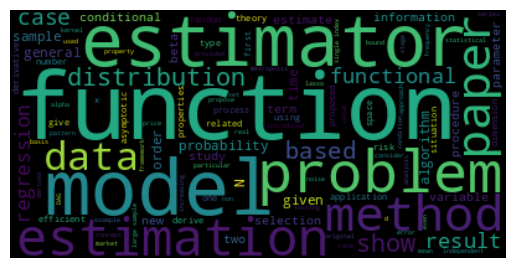

{'estimation': 22, 'data': 21, 'function': 20, 'show': 20, 'distribution': 17, 'estimator': 16, 'problem': 15, 'based': 14, 'random': 14}


In [32]:
def run():
  sc = init_spark()[0]
  arxiv_dataset = load_data_from_json(sc, "part1.json")
  show_word_cloud(arxiv_dataset, "stat.TH")
  show_word_top(arxiv_dataset, "stat.TH", 10)

run()